# Experimentos

## Imports

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import pandas as pd
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'skimage'

In [5]:
%run utils.py

In [6]:
# Usada para testear
image_name = 'FM000020_03' # piñera

## Probar funciones utils

TODO: Todo lo que está bajo este título se podría borrar, son sólo pruebas de funciones (i.e. no es necesario ejecutarlo).

### Cargar una imagen del dataset

Original shape:  (256, 256, 3)
Gray shape:  (256, 256)
Crop+gray shape:  (128, 256)


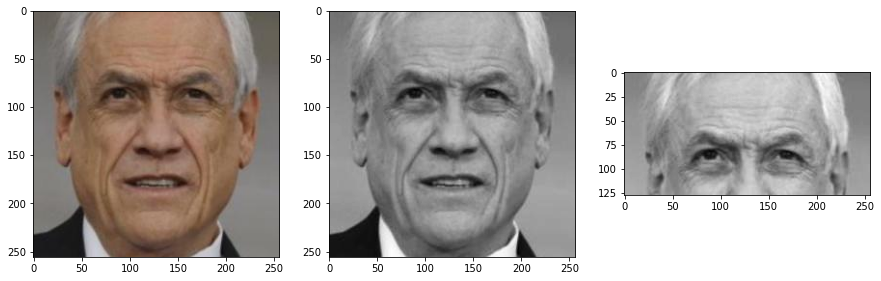

In [44]:
img = load_image(image_name)
print('Original shape: ', img.shape)

img_gray = load_image(image_name, gray=True)
print('Gray shape: ', img_gray.shape)

img_crop = load_image(image_name, gray=True, crop=True)
print('Crop+gray shape: ', img_crop.shape)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.imshow(img_gray, cmap='gray')

plt.subplot(1, 3, 3)
plt.imshow(img_crop, cmap='gray')

### Cargar un dataset de las N primeras imagenes de un dataset

In [45]:
datasetA = load_dataset(16, gray=True, crop=True)
# Lista de: [image, image_name, i_image (label/persona), j (image_number 1-6)]

len(datasetA)

96

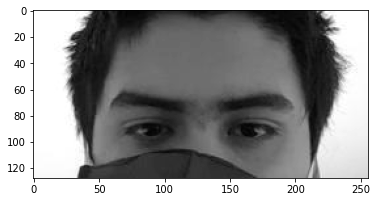

In [46]:
plt.imshow(datasetA[5][0], cmap='gray')

### Plotear matriz de confusión

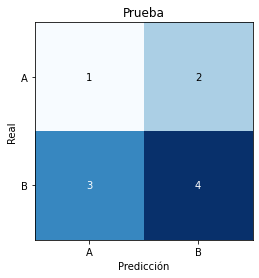

In [47]:
plot_cm(np.array([[1, 2], [3, 4]]), title='Prueba', labels=['A', 'B'])

## Crear DataFrame con features

Se crea un `pd.DataFrame` que contiene los features y las labels de cada imagen.
Se puede crear un DF para cada dataset (A, B, C, D).

Más adelante se le van agregando los features a este DataFrame, para evitar recalcularlos.


In [7]:
datasetA = load_dataset(16, gray=True, crop=True)
print(len(datasetA))

df_A = create_df(datasetA)
df_A.head(6)

96


,label,image_number
FM000001_01,1,1
FM000001_02,1,2
FM000001_03,1,3
FM000001_04,1,4
FM000001_05,1,5
FM000001_06,1,6


## Calcular features

### LBP

Se aplica LBP de la librería `skimage`.

In [8]:
from skimage.feature import local_binary_pattern

#### Ejemplo LBP

In [9]:
image = load_image('FM000020_03', gray=True, crop=True)
image.shape

(128, 256)

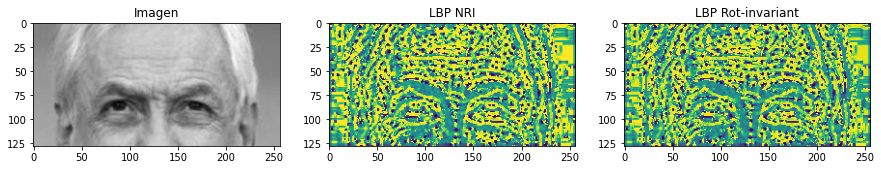

In [50]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Imagen')
plt.imshow(image, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('LBP NRI')
radius = 3
plt.imshow(local_binary_pattern(image, 8*radius, radius, method='nri_uniform'))

plt.subplot(1, 3, 3)
plt.title('LBP Rot-invariant')
radius = 3
plt.imshow(local_binary_pattern(image, 8*radius, radius, method='uniform'))

#### Función para calcular histograma de LBP

In [10]:
def calculate_lbp(image, n_vertical=4, n_horizontal=8, radius=1, method='nri_uniform'):
    """Se calcula LBP para una imagen, considerando crops horizontales y verticales."""
    
    global_features = []

    for horizontal_patch in np.array_split(image, n_horizontal, axis=1):
        for patch in np.array_split(horizontal_patch, n_vertical, axis=0):
            local_features = local_binary_pattern(patch, 8*radius, radius, method=method)

            # Computar histograma
            n_bins = int(local_features.max() + 1)
            lbp_hist, _ = np.histogram(local_features, bins=n_bins)
            
            global_features.append(lbp_hist)
            
    # Pad local_features to reach same size
    max_feature = max(len(arr) for arr in global_features)
    global_features = np.array([np.pad(arr, (0, max_feature - len(arr))) for arr in global_features])

    return global_features.flatten()

LPB size:  1888


Text(0.5, 1.0, 'Histogramas LBP concatenados')

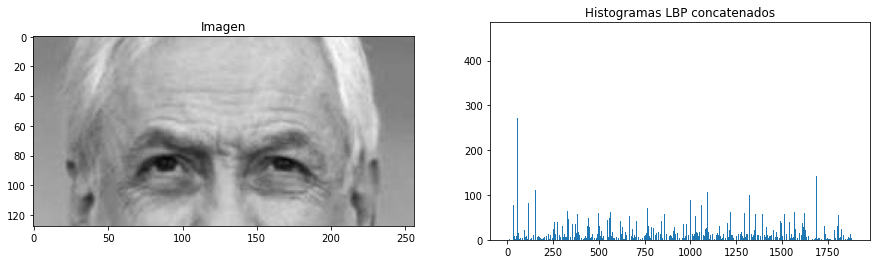

In [11]:
image = load_image('FM000020_03', gray=True, crop=True)

lbp = calculate_lbp(image, n_vertical=4, n_horizontal=8, method='nri_uniform')
print('LPB size: ', len(lbp))

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen')

plt.subplot(1, 2, 2)
plt.bar(range(len(lbp)), lbp)
plt.title('Histogramas LBP concatenados')

#### Calcular LBP para todo el dataset

In [12]:
LBP_COMBINATIONS = [(4,8), (2,6), (4,4)] 

In [13]:
%%time

for lbp_combination in LBP_COMBINATIONS:
    n_v, n_h = lbp_combination
    lbp_name = f'lbp-{n_v}-{n_h}'
    
    lbp_df = calculate_feature_df(datasetA, calculate_lbp, lbp_name, radius=1, method='nri_uniform',
                                  n_vertical=n_v, n_horizontal=n_h)
    
    df_A = df_A.merge(lbp_df, right_index=True, left_index=True)

Calculating lbp-4-8
Calculating lbp-2-6
Calculating lbp-4-4
CPU times: user 3.4 s, sys: 24.2 ms, total: 3.42 s
Wall time: 3.5 s


In [14]:
df_A.head()

,label,image_number,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,...,lbp-4-4_934,lbp-4-4_935,lbp-4-4_936,lbp-4-4_937,lbp-4-4_938,lbp-4-4_939,lbp-4-4_940,lbp-4-4_941,lbp-4-4_942,lbp-4-4_943
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,6,13,20,1,31,19,13,5,442,94
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,16,16,4,11,9,17,7,15,60,104
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,9,22,8,10,9,21,10,5,93,133
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0,2,7,1,26,7,5,0,1054,41
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,4,11,6,4,22,21,9,2,793,58


### Gabor

In [17]:
from pybalu import feature_extraction as balu

#### Ejemplo

<BarContainer object of 67 artists>

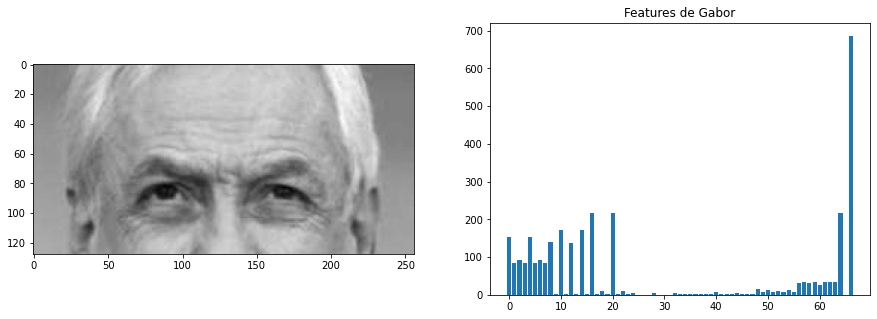

In [19]:
image = load_image(image_name, gray=True, crop=True)

gabor = balu.gabor_features(image, labels=False)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Features de Gabor')
plt.bar(range(len(gabor)), gabor)

#### Calcular para todo el dataset

TODO: se podrían agregar más hiperparámetros, por ahora sólo probé los valores por defecto de pybalu.

In [15]:
def calculate_gabor(image):
    """Se calculan features de Gabor para una imagen."""
    gabor = balu.gabor_features(image, labels=False)
    return gabor

In [18]:
%%time

gabor_df = calculate_feature_df(datasetA, calculate_gabor, 'gabor')

df_A = df_A.merge(gabor_df, right_index=True, left_index=True)
df_A.head()

Calculating gabor
CPU times: user 56.2 s, sys: 335 ms, total: 56.6 s
Wall time: 56.9 s


,label,image_number,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,...,gabor_57,gabor_58,gabor_59,gabor_60,gabor_61,gabor_62,gabor_63,gabor_64,gabor_65,gabor_66
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,37.018313,32.585398,39.327933,38.180749,38.847801,33.727193,36.788572,231.110568,0.409503,563.368794
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,42.575885,38.445190,44.662112,36.376333,44.419227,39.900975,42.272625,263.301036,0.309980,848.412823
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,35.351814,33.058322,37.069129,34.631370,40.491354,35.813445,36.986914,215.215069,0.345489,621.929334
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,43.773557,39.738751,43.998635,34.774928,43.548543,40.771284,44.033367,273.845165,0.480563,568.842939
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,35.036617,31.169075,36.378489,33.786453,35.297841,32.158856,35.247160,214.417845,0.516277,414.315296


### HoG

TODO: se pueden probar más combinaciones de hiper-parámetros.

In [1]:
def calculate_hog(image, pix=8, visualize=False):
    """Calcular vector de caracteristicas de HoG para una imagen."""
    return skimage.feature.hog(image,
                               pixels_per_cell=(pix, pix),
                               cells_per_block=(1, 1),
                               feature_vector=True,
                               visualize=visualize)

#### Ejemplo

In [25]:
image = load_image(image_name)

hog = calculate_hog(image)
hog.shape

(9216,)

<BarContainer object of 9216 artists>

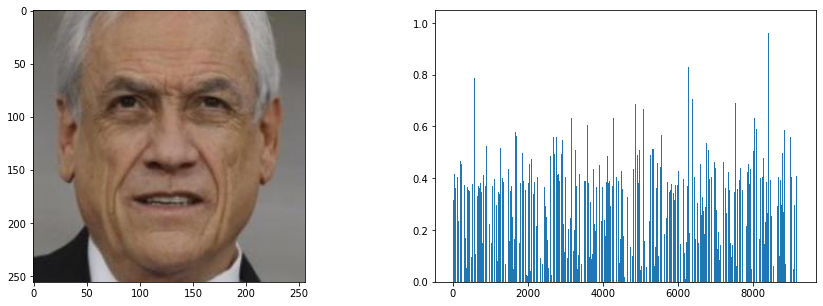

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.bar(range(len(hog)), hog)

#### Calcular HoG para todo el dataset

In [26]:
%%time

hog_df = calculate_feature_df(datasetA, calculate_hog, 'hog')

df_A = df_A.merge(hog_df, right_index=True, left_index=True)
df_A.head()

Calculating hog
CPU times: user 1.72 s, sys: 12.1 ms, total: 1.73 s
Wall time: 1.74 s


,label,image_number,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,...,hog_4598,hog_4599,hog_4600,hog_4601,hog_4602,hog_4603,hog_4604,hog_4605,hog_4606,hog_4607
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,0.159582,0.325244,0.233331,0.387690,0.387690,0.387690,0.387690,0.387690,0.297081,0.000000
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,0.160637,0.379657,0.057831,0.379657,0.367913,0.379657,0.168373,0.379657,0.379657,0.335034
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,0.000000,0.613382,0.000000,0.497519,0.000000,0.613382,0.000000,0.000000,0.000000,0.000000


### Haralick

TODO: también se pueden probar más combinaciones de hiper-parámetros.

In [27]:
from pybalu import feature_extraction as balu

In [34]:
def calculate_haralick(image, distance=[1, 3, 8, 20]):
    """Se calcula un vector de características de Haralick para una imagen.
    
    Funciona solo con imagenes en tono de grises.
    """
    har = balu.haralick_features(image, distance=distance)
    
    return har

#### Ejemplo

In [32]:
image = load_image(image_name, gray=True)
image.shape

(256, 256)

In [33]:
har = calculate_haralick(image)
len(har)

112

<BarContainer object of 112 artists>

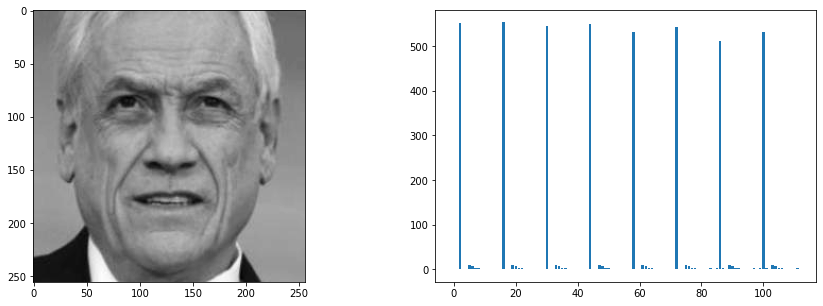

In [35]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.bar(range(len(har)), har)

#### Calcular Haralick para todo el dataset

In [36]:
%%time

haralick_df = calculate_feature_df(datasetA, calculate_haralick, 'haralick')

df_A = df_A.merge(haralick_df, right_index=True, left_index=True)
df_A.head()

Calculating haralick
CPU times: user 1.57 s, sys: 459 ms, total: 2.03 s
Wall time: 1.06 s


,label,image_number,lbp-4-8_0,lbp-4-8_1,lbp-4-8_2,lbp-4-8_3,lbp-4-8_4,lbp-4-8_5,lbp-4-8_6,lbp-4-8_7,...,haralick_102,haralick_103,haralick_104,haralick_105,haralick_106,haralick_107,haralick_108,haralick_109,haralick_110,haralick_111
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,0.702851,8.379669,6.290701,2.190982,3.017540,0.041066,1.688582,0.298658,0.606052,1.262888
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,0.582302,9.895166,7.655817,2.249493,3.419914,0.021327,1.750417,0.097105,0.279537,1.387097
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,0.624571,8.421179,6.354381,2.201073,3.347930,0.028251,1.652116,0.120142,0.328648,1.220561
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0.644832,10.076585,7.832322,2.301889,3.504951,0.031538,1.610312,0.195041,0.493492,1.335625
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,0.661396,7.864132,5.712508,2.265340,3.319862,0.032194,1.726176,0.214327,0.520734,1.200304


### SIFT

TODO

### TODO: Otros features

Acá se pueden agregar otro cálculo de features, y guardarlos en el dataframe.

## Normalizar

Normalización de columnas.
* Se normalizan todas las columnas de features en el rango (0,1).
* Para calcular el rango de normalización se usan sólo las imágenes de training.
* Por defecto, se mantienen las columnas normalizadas en el DataFrame y las no normalizadas también, con el sufijo `'_nonorm'`. Esto para que también se puedan hacer pruebas con las columnas no normalizadas, si se desea.

(Ver función `normalize_df()` en `utils.py`).

Nota(pablo): Esta función debería ser ejecutada sólo una vez, no estoy 100% seguro si el dataframe quedará feo con algo como 'hog_3_nonorm_nonorm_nonorm' (no debería, pero no lo he probado tanto).

In [37]:
df_A = normalize_df(df_A)
df_A.head()

,label,image_number,lbp-4-8_0_nonorm,lbp-4-8_1_nonorm,lbp-4-8_2_nonorm,lbp-4-8_3_nonorm,lbp-4-8_4_nonorm,lbp-4-8_5_nonorm,lbp-4-8_6_nonorm,lbp-4-8_7_nonorm,...,haralick_102,haralick_103,haralick_104,haralick_105,haralick_106,haralick_107,haralick_108,haralick_109,haralick_110,haralick_111
FM000001_01,1,1,24,9,0,6,1,18,0,9,...,0.642669,0.601902,0.653262,0.531175,0.444299,0.581653,0.697384,0.813890,0.766874,0.650139
FM000001_02,1,2,9,17,0,14,0,11,0,8,...,0.312568,0.897455,0.932293,0.585842,0.658784,0.167341,0.789856,0.052146,0.017956,0.846064
FM000001_03,1,3,30,6,0,20,0,8,0,32,...,0.428312,0.609997,0.666279,0.540602,0.620413,0.312683,0.642850,0.139211,0.130600,0.583373
FM000001_04,1,4,27,32,0,3,2,23,1,11,...,0.483795,0.932835,0.968371,0.634796,0.704113,0.381661,0.580334,0.422285,0.508700,0.764873
FM000001_05,1,5,29,16,0,4,1,20,1,2,...,0.529152,0.501362,0.535079,0.600648,0.605451,0.395424,0.753605,0.495173,0.571183,0.551421


## Experimentos clasificación

In [38]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.metrics import accuracy_score, confusion_matrix

In [39]:
def split_train_val_test(df):
    """Se hace split de un dataframe en train, val, test.
    
    Args:
        df -- formato retornado por `create_df()`
    """
    train = df.loc[df['image_number'] < 4]
    val = df.loc[df['image_number'] == 4]
    test = df.loc[df['image_number'] > 4]
    return train, val, test

In [40]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, cm

In [41]:
def run_experiment(dataset_df, train_cols,
                   method='KNN', n_neighbors=3, hidden_layer_sizes=(100,),
                   option='validation', show_cm=True, **kwargs):
    # Split train, val, test
    train, val, test = split_train_val_test(dataset_df)

    # Seleccionar columnas para entrenar
    x_train = train[train_cols]
    y_train = train['label']

    if option == 'validation' or option == 'val':
        x_val = val[train_cols]
        y_val = val['label']
    elif option == 'test':
        x_val = test[train_cols]
        y_val = test['label']
    else:
        raise Exception(f'Option not recognized: {option}')

    
    # Elegir clasificador
    if method == 'KNN':
        model = KNN(n_neighbors=n_neighbors, **kwargs)
    elif method == 'SVM':
        model = SVC(**kwargs)
    elif method == 'MLP':
        model = MLP(hidden_layer_sizes=hidden_layer_sizes, **kwargs)
    else:
        raise Exception(f'Unkwown model: {method}')
        
    # Entrenar clasificador
    print('Training...')
    model.fit(x_train, y_train)
    
    # Evaluar modelo
    train_accuracy, train_cm = evaluate(model, x_train, y_train)
    val_accuracy, val_cm = evaluate(model, x_val, y_val)
    
    print(f'Accuracy: train: {train_accuracy}, {option}: {val_accuracy}')
    if show_cm:
        plot_cm(val_cm, title=f'{option} CM')

    return val_accuracy

In [61]:
def find_best_strategy(df, cols, strategies, option='val'):
    """Corre experimentos con distintas estrategias, y retorna la mejor estrategia.
    
    Args:
        df -- dataframe de un dataset
        cols -- set de columnas a usar para el experimento
        strategies -- lista de estrategias: diccionario con argumentos a pasar a `run_experiment()`
            (ver ejemplos mas abajo)
        option -- con que set testear (val o test)
    """
    results = []

    for strategy in strategies:
        acc = run_experiment(df, cols, option=option, show_cm=False, **strategy)

        results.append((acc, strategy))

    results = sorted(results, key=lambda x:x[0], reverse=True)
    best_acc, best_strategy = results[0]
    # print('Best result: ', best_acc, best_strategy)
    
    return best_acc, best_strategy

### Probar mejor estrategia con LBP

In [43]:
%%time

# TODO: esto se podria hacer refactor con la funcion find_best_strategy(), ver ejemplos HoG mas abajo

best_accuracy = 0
best_n_v = 0
best_n_h = 0
best_strategy = 0

# Evaluamos todas las estrategias y nos quedamos con la mejor, para distintas variantes de LBP
for lbp_combination in LBP_COMBINATIONS:
    n_v, n_h = lbp_combination
    
    lbp_basename = f'lbp-{n_v}-{n_h}'
    train_cols = [col for col in df_A.columns if col.startswith(lbp_basename) and not col.endswith('_nonorm')]

    for strategy in ('KNN', 'SVM', 'MLP'):
        print(f'Experiment with n_vertical = {n_v}, n_horizontal={n_h}, strategy = {strategy}', end='\t')

        # Corremos el experimento
        accuracy = run_experiment(df_A, train_cols, method=strategy, show_cm=False)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_v = n_v
            best_n_h = n_h
            best_strategy = strategy

print(f'Best strategy: {best_strategy}, n_vertical={best_n_v}, n_horizontal={best_n_h}, val acc {best_accuracy}')

Experiment with n_vertical = 4, n_horizontal=8, strategy = KNN	Training...
Accuracy: train: 0.7291666666666666, validation: 0.6875
Experiment with n_vertical = 4, n_horizontal=8, strategy = SVM	Training...
Accuracy: train: 1.0, validation: 0.5625
Experiment with n_vertical = 4, n_horizontal=8, strategy = MLP	Training...
Accuracy: train: 1.0, validation: 0.625
Experiment with n_vertical = 2, n_horizontal=6, strategy = KNN	Training...
Accuracy: train: 0.6458333333333334, validation: 0.5
Experiment with n_vertical = 2, n_horizontal=6, strategy = SVM	Training...
Accuracy: train: 1.0, validation: 0.625
Experiment with n_vertical = 2, n_horizontal=6, strategy = MLP	Training...
Accuracy: train: 1.0, validation: 0.625
Experiment with n_vertical = 4, n_horizontal=4, strategy = KNN	Training...
Accuracy: train: 0.6458333333333334, validation: 0.5625
Experiment with n_vertical = 4, n_horizontal=4, strategy = SVM	Training...
Accuracy: train: 1.0, validation: 0.625
Experiment with n_vertical = 4, n_

Training...
Accuracy: train: 0.7083333333333334, test: 0.59375


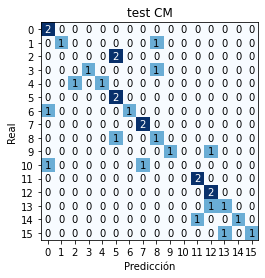

0.59375

In [44]:
# Corremos con la mejor estrategia

lbp_basename = f'lbp-{best_n_v}-{best_n_h}'
cols = [col for col in df_A.columns if col.startswith(lbp_basename)]

# Corremos el experimento utilizando el testing set
run_experiment(df_A, cols, method=best_strategy, option='test')

### Probar Gabor

In [52]:
gabor_cols = [col for col in df_A.columns if col.startswith('gabor') and not col.endswith('_nonorm')]
len(gabor_cols)

67

Training...
Accuracy: train: 0.5208333333333334, val: 0.375


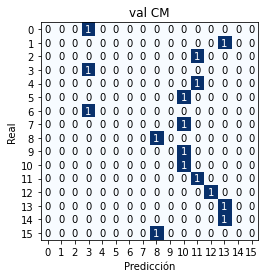

0.375

In [46]:
run_experiment(df_A, gabor_cols, method='SVM', option='val', kernel='rbf')

Training...
Accuracy: train: 0.5, val: 0.4375


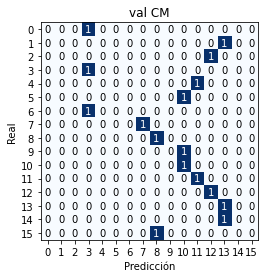

0.4375

In [47]:
run_experiment(df_A, gabor_cols, method='SVM', option='val', kernel='linear')

Training...
Accuracy: train: 0.375, val: 0.375


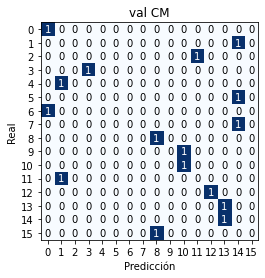

0.375

In [48]:
run_experiment(df_A, gabor_cols, method='KNN', option='val', n_neighbors=5)

Training...


/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: train: 1.0, val: 0.3125


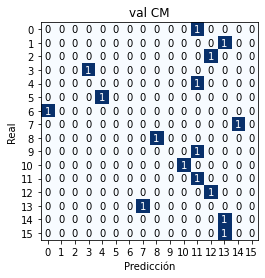

0.3125

In [49]:
run_experiment(df_A, gabor_cols, method='MLP', option='val', max_iter=1000)

### Probar HoG

In [53]:
hog_cols = [col for col in df_A.columns if col.startswith('hog') and not col.endswith('_nonorm')]
len(hog_cols)

4608

In [55]:
strategies = [
    { 'method': 'SVM', 'kernel': 'rbf' },
    { 'method': 'SVM', 'kernel': 'linear' },
    { 'method': 'KNN', 'n_neighbors': 5 },
    { 'method': 'KNN', 'n_neighbors': 3 },
    { 'method': 'MLP' },
]

In [62]:
best_acc, best_strategy = find_best_strategy(df_A, hog_cols, strategies)

print('Best result: ', best_acc, best_strategy)

Training...
Accuracy: train: 1.0, val: 0.875
Training...
Accuracy: train: 1.0, val: 0.875
Training...
Accuracy: train: 0.7291666666666666, val: 0.625
Training...
Accuracy: train: 0.8125, val: 0.5625
Training...
Accuracy: train: 1.0, val: 0.75
Best result:  0.875 {'method': 'SVM', 'kernel': 'rbf'}


Training...
Accuracy: train: 1.0, test: 0.8125


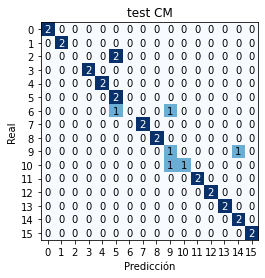

0.8125

In [63]:
# Correr mejor estrategia en testing

run_experiment(df_A, hog_cols, option='test', show_cm=True, **best_strategy)

### Probar Haralick

In [64]:
har_cols = [col for col in df_A.columns if col.startswith('haralick') and not col.endswith('_nonorm')]
len(har_cols)

112

In [65]:
strategies = [
    { 'method': 'SVM', 'kernel': 'rbf' },
    { 'method': 'SVM', 'kernel': 'linear' },
    { 'method': 'KNN', 'n_neighbors': 5 },
    { 'method': 'KNN', 'n_neighbors': 3 },
    { 'method': 'MLP' },
]

In [66]:
best_acc, best_strategy = find_best_strategy(df_A, har_cols, strategies)

print('Best result: ', best_acc, best_strategy)

Training...
Accuracy: train: 0.6875, val: 0.375
Training...
Accuracy: train: 0.7916666666666666, val: 0.3125
Training...
Accuracy: train: 0.4375, val: 0.3125
Training...
Accuracy: train: 0.6041666666666666, val: 0.125
Training...
Accuracy: train: 0.9791666666666666, val: 0.5
Best result:  0.5 {'method': 'MLP'}


/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training...


/home/pablo/univ-local/patrones/proyecto/pyenv/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: train: 0.9791666666666666, test: 0.40625


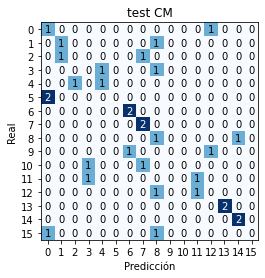

0.40625

In [67]:
# Correr mejor estrategia en testing

run_experiment(df_A, har_cols, option='test', show_cm=True, **best_strategy)